<a href="https://colab.research.google.com/github/sepandms/SkinCare/blob/main/CNN_60x45.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.transforms.Compose
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
import time
import pickle
from statistics import mean
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
device = 'mps'
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
#path = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Data/Pickle_Data/'
#p_models = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Models/Saved/'
#device = torch.device("cpu")
path = '/content/drive/MyDrive/DataSources/'

In [3]:
# file = 'DataSource_60x45_blc.pickle' 
file = 'DataSource_60x45_blc_noDup.pickle' 
data = pd.read_pickle(path + file)

train_data = data[data.type=='train']
valid_data = data[data.type=='valid']
test_data = data[data.type=='test']

training_data = pd.concat([train_data,valid_data], axis=0)
print('Train size: ',train_data.shape[0] ,' Valid Size: ',valid_data.shape[0], ' Test size: ', test_data.shape[0])

FileNotFoundError: ignored

# **Standardize Train and Validation data**

In [ ]:
training_arrays = np.stack(training_data['img_array'].values)  
training_arrays_scaled = training_arrays / 255
Mean = training_arrays_scaled.mean(axis = (0,1,2)) 
STD = training_arrays_scaled.std(axis = (0,1,2))
print(f"Mean : {Mean}   STD: {STD}") 

Mean : [0.74792757 0.55122558 0.57589093]   STD: [0.13827099 0.14719015 0.16298904]


In [ ]:
#Train data standardization
train_arrays_std = np.stack(train_data['img_array'].values) / 255
for i in range(0,train_arrays_std.shape[0]):
    train_arrays_std[i] = (train_arrays_std[i] - Mean) / STD
#Validation data standardization
valid_arrays_std = np.stack(valid_data['img_array'].values) / 255
for i in range(0,valid_arrays_std.shape[0]):
    valid_arrays_std[i] = (valid_arrays_std[i] - Mean) / STD
#Test data standardization
test_arrays_std = np.stack(test_data['img_array'].values) / 255
for i in range(0,test_arrays_std.shape[0]):
    test_arrays_std[i] = (test_arrays_std[i] - Mean) / STD

In [ ]:
Mean_t = train_arrays_std.mean(axis = (0,1,2)) 
STD_t = train_arrays_std.std(axis = (0,1,2))
print(f"Mean : {Mean_t}   STD: {STD_t}") 

Mean : [0.00409393 0.00544143 0.00429412]   STD: [1.00757386 1.00169216 1.00082682]


In [ ]:
train_arrays_std_T = torch.tensor(train_arrays_std, dtype= torch.float32).transpose(3,1)
train_labels = torch.tensor(train_data['label_id'].values.astype(np.long))

valid_arrays_std_T = torch.tensor(valid_arrays_std, dtype= torch.float32).transpose(3,1)
valid_labels = torch.tensor(valid_data['label_id'].values.astype(np.long))

test_arrays_std_T = torch.tensor(test_arrays_std, dtype= torch.float32).transpose(3,1)
test_labels = torch.tensor(test_data['label_id'].values.astype(np.long))

input_data = (train_arrays_std_T , valid_arrays_std_T, test_arrays_std_T , torch.cat((train_arrays_std_T,valid_arrays_std_T,test_arrays_std_T),0) )
labels = (train_labels,valid_labels,test_labels , torch.cat((train_labels,valid_labels,test_labels),0))

# **Show some Images**

--------Original Image----------
i:  ISIC_0029731
Image:164, target:bkl


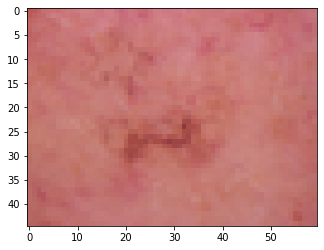

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------Normilized Image---------


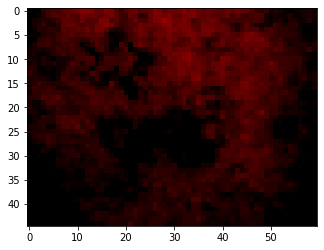

###################################
--------Original Image----------
i:  ISIC_0025439
Image:1326, target:mel


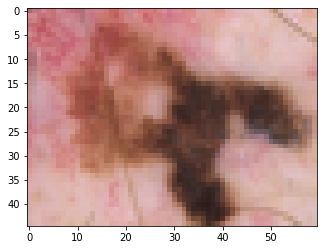

---------Normilized Image---------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


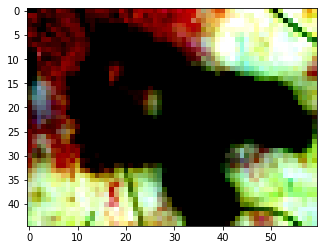

###################################
--------Original Image----------
i:  ISIC_0027956
Image:388, target:mel


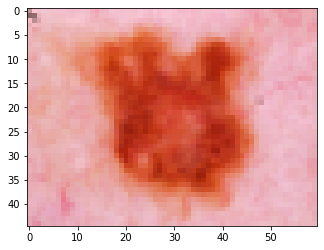

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------Normilized Image---------


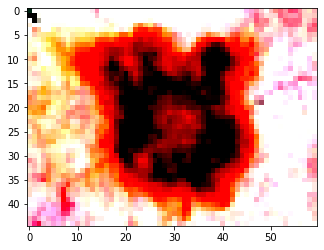

###################################


In [ ]:
for i in np.random.choice(train_data.shape[0], 3, replace=False):
  print("--------Original Image----------")
  print('i: ', train_data['image_id'].iloc[i])
  image1 = torch.from_numpy(train_data['img_array'].iloc[i])
  print("Image:{}, target:{}".format(i, train_data['image_label'].iloc[i]))
  plt.imshow(image1, interpolation='nearest')
  plt.show()
  print("---------Normilized Image---------")
  image2 = train_arrays_std[i]
  plt.imshow(image2, interpolation='nearest')
  plt.show()
  print("###################################")

### **1.2 Nets**

In [ ]:
class CNN_Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
        self.conv2 = nn.Conv2d( in_channels=32, out_channels=32 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
        self.conv4 = nn.Conv2d( in_channels=64, out_channels=64 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.fc1   = nn.Linear(in_features= 6144 , out_features = 512)
        self.fc2   = nn.Linear(in_features= 512, out_features = 7)
        self.Act   = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.Act(self.conv1(x))
        out = self.Act(self.conv2(out))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv3(out))
        out = self.Act(self.conv4(out))
        out = self.Act(self.pool2(out))
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.Act(self.fc2(out))
        # out = nn.Softmax(out)
        return out

In [ ]:
class CNN_Net2(nn.Module):
    def __init__(self):
        super(CNN_Net2, self).__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
        # self.conv2 = nn.Conv2d( in_channels=32, out_channels=32 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
        # self.conv4 = nn.Conv2d( in_channels=64, out_channels=64 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.fc1   = nn.Linear(in_features= 7488 , out_features = 512)
        self.fc2   = nn.Linear(in_features= 512, out_features = 7)
        self.Act   = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.Act(self.conv1(x))
        # out = self.Act(self.conv2(out))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv3(out))
        # out = self.Act(self.conv4(out))
        out = self.Act(self.pool2(out))
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.Act(self.fc2(out))
        # out = nn.Softmax(out)
        return out

In [ ]:
class CNN_Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 40, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(40, 60, 4)
        self.conv3 = nn.Conv2d(60, 20, 3)
        self.fc1 = nn.Linear(38480, 512) #180, 45920
        self.fc2 = nn.Linear(512, 100)
        self.fc3 = nn.Linear(100, 7)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# **Test Nets**

In [ ]:
model_test = CNN_Net2()
X_ = input_data[0][0:5]
out = model_test(X_)
out.shape

torch.Size([5, 7])

# **Confusion-Matrix & Accuracy**

In [ ]:
def confusion_matrix(Y_pred,Y):
    CM = sk.metrics.confusion_matrix(Y_pred,Y)
    Total_sum = sum(sum(CM))
    Diagonal_sum = np.trace(CM) 
    accuracy1 = Diagonal_sum / Total_sum
    frequencies = list(pd.DataFrame(Y).value_counts())
    weights = list(np.divide(frequencies, Total_sum))
    sensitivity = []
    specificity = []
    for i in range(0,7):
        sensitivity_ = CM[i,i].sum() / (CM[i].sum())
        sensitivity.append(sensitivity_)
        specificity_ = (Diagonal_sum - CM[i,i]) / (  (Diagonal_sum - CM[i,i]) + (CM.T[i].sum()-CM[i,i]))
        specificity.append(specificity_)
        
    print('Nr. of Data : \n', Total_sum)
    print('Accuracy of The Model : \n', accuracy1)
    print('Confusion Matrix : \n', CM)
    print('Weighted Avg. of sensitivity : \n', np.average(np.nan_to_num(sensitivity), weights=weights))
    print('Weighted Avg. of specificity : \n', np.average(np.nan_to_num(specificity), weights=weights))
    sk.metrics.ConfusionMatrixDisplay(CM).plot()

### **1.3 Training**

In [ ]:
# Training
class Model_Training:

    def __init__(self, model , loss_func, optimizer, epochs, batch_size , X_train, Y_train, X_valid, Y_valid ):
        
        self.model = model
        self.loss_func = loss_func
        self.opt = optimizer
        self.epochs = epochs
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.batch_size = batch_size
        self.Epochs_Train_loss = []
        self.Epochs_Train_Acc = []
        self.Epochs_Val_loss = []
        self.Epochs_Val_Acc = []

    def Train_CNNs(self):
        
        model = self.model
        loss_fn = self.loss_func
        opt = self.opt 
        batch_size = self.batch_size
        nr_of_steps_train =  self.X_train.shape[0]//self.batch_size 
        nr_of_steps_valid =  self.X_valid.shape[0]//self.batch_size 

        for epoch in range(1, epochs+1 ):
            start_time=time.time()
            steps_train_loss = []
            steps_train_Acc = []
            steps_val_loss = []
            steps_val_Acc = []

            for i in range(0, nr_of_steps_train ):#train_arrays_std.shape[0]):
                X = self.X_train[i* batch_size:(i+1) * batch_size]
                Y = self.Y_train[i * batch_size:(i+1) * batch_size]
                opt.zero_grad()
                model.train()
                y_pred = model.forward(X.to(device))
                loss = loss_fn(y_pred, Y.to(device))
                loss.backward()
                opt.step()
                y_pred_labels = y_pred.argmax(axis=1)
                nr_of_corrects = (y_pred_labels == Y.to(device)).sum().item()
                step_acc = nr_of_corrects / batch_size
                steps_train_Acc.append(step_acc)
                steps_train_loss.append(loss.item())

                # if (i+1) % 200 == 0:    # print every 2000 mini-batches
                #     print('[Epoch: {}, Nr. Batch: {}]  , Train-Steps-loss: {:.1f} , running_acc: {:.1%}'.format(epoch , i+1 , train_steps_loss , batch_nr_correct / train_nr_total))
                #     self.train_steps_acc = []
                #     train_steps_loss = 0

              #validation loss calculation
            for j in range(0,nr_of_steps_valid):

                val_X = self.X_valid[j*batch_size:(j+1)*batch_size]
                val_Y = self.Y_valid[j*batch_size:(j+1)*batch_size]
                model.eval()
                # val_inputs = val_inputs.to(device)
                # val_labels = val_labels.to(device)
                val_outputs = model(val_X.to(device))
                val_loss = loss_fn(val_outputs, val_Y.to(device))
                val_epoch_loss = val_loss.item()
                val_outputs_lbs= val_outputs.argmax(axis=1)
                val_nr_correct = (val_outputs_lbs == val_Y.to(device)).sum().item()
                step_acc = val_nr_correct / batch_size
                steps_val_Acc.append(step_acc)
                steps_val_loss.append(val_epoch_loss)
            
            # Epoch Performance Metrics
            train_epoch_loss = mean(steps_train_loss)
            train_epoch_Acc = mean(steps_train_Acc)
            self.Epochs_Train_loss.append(train_epoch_loss)
            self.Epochs_Train_Acc.append(train_epoch_Acc)   
            val_epoch_loss = mean(steps_val_loss)
            val_epoch_Acc = mean(steps_val_Acc)
            self.Epochs_Val_loss.append(val_epoch_loss)
            self.Epochs_Val_Acc.append(val_epoch_Acc)
            End_time = time.time()   
            print('[Epoch: {}]  , Train_loss: {:.1f} , Train_Acc: {:.1%}, Val_loss: {:.1f} , Val_Acc: {:.1%} , run time: {}'
            .format(epoch , train_epoch_loss , train_epoch_Acc , val_epoch_loss , val_epoch_Acc, np.round(End_time - start_time, 2)))
            
        print('Finished Training')

In [ ]:
# Training
class Model_Training_0:

    def __init__(self, model , loss_func, optimizer, epochs, batch_size , X_train, Y_train, X_valid, Y_valid ):
        
        self.model = model
        self.loss_func = loss_func
        self.opt = optimizer
        self.epochs = epochs
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.batch_size = batch_size
        self.Epochs_Train_loss = []
        self.Epochs_Train_Acc = []
        self.Epochs_Val_loss = []
        self.Epochs_Val_Acc = []

    def Train_CNNs(self):
        
        model = self.model 
        loss_fn = self.loss_func 
        opt = self.opt 
        batch_size = self.batch_size
        nr_of_steps_train =  self.X_train.shape[0]//self.batch_size 
        nr_of_steps_valid =  self.X_valid.shape[0]//self.batch_size 

        for epoch in range(1, epochs+1 ):
            start_time=time.time()
            steps_train_loss = []
            steps_train_Acc = []
            steps_val_loss = []
            steps_val_Acc = []

            for i in range(0, nr_of_steps_train ):#train_arrays_std.shape[0]):
                X = self.X_train[i* batch_size:(i+1) * batch_size]
                Y = self.Y_train[i * batch_size:(i+1) * batch_size]
                opt.zero_grad()
                model.train()
                y_pred = model.forward(X)
                loss = loss_fn(y_pred, Y)
                loss.backward()
                opt.step()
                y_pred_labels = y_pred.argmax(axis=1)
                nr_of_corrects = (y_pred_labels == Y).sum().item()
                step_acc = nr_of_corrects / batch_size
                steps_train_Acc.append(step_acc)
                steps_train_loss.append(loss.item())

                # if (i+1) % 200 == 0:    # print every 2000 mini-batches
                #     print('[Epoch: {}, Nr. Batch: {}]  , Train-Steps-loss: {:.1f} , running_acc: {:.1%}'.format(epoch , i+1 , train_steps_loss , batch_nr_correct / train_nr_total))
                #     self.train_steps_acc = []
                #     train_steps_loss = 0

              #validation loss calculation
            for j in range(0,nr_of_steps_valid):

                val_X = self.X_valid[j*batch_size:(j+1)*batch_size]
                val_Y = self.Y_valid[j*batch_size:(j+1)*batch_size]
                model.eval()
                # val_inputs = val_inputs
                # val_labels = val_labels
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_Y)
                val_epoch_loss = val_loss.item()
                val_outputs_lbs= val_outputs.argmax(axis=1)
                val_nr_correct = (val_outputs_lbs == val_Y).sum().item()
                step_acc = val_nr_correct / batch_size
                steps_val_Acc.append(step_acc)
                steps_val_loss.append(val_epoch_loss)
            
            # Epoch Performance Metrics
            train_epoch_loss = mean(steps_train_loss)
            train_epoch_Acc = mean(steps_train_Acc)
            self.Epochs_Train_loss.append(train_epoch_loss)
            self.Epochs_Train_Acc.append(train_epoch_Acc)   
            val_epoch_loss = mean(steps_val_loss)
            val_epoch_Acc = mean(steps_val_Acc)
            self.Epochs_Val_loss.append(val_epoch_loss)
            self.Epochs_Val_Acc.append(val_epoch_Acc)
            End_time = time.time()   
            print('[Epoch: {}]  , Train_loss: {:.1f} , Train_Acc: {:.1%}, Val_loss: {:.1f} , Val_Acc: {:.1%} , run time: {}'
            .format(epoch , train_epoch_loss , train_epoch_Acc , val_epoch_loss , val_epoch_Acc, np.round(End_time - start_time, 2)))
            
        print('Finished Training')

In [ ]:
class Model_Training2:

    def __init__(self, Net, LR, batch_size , Momentum, epochs, weight_decay, loss_func, opt_func, X_train, Y_train, X_valid, Y_valid):    
        
        self.model = Net().to(device)
        
        if opt_func is torch.optim.Adam:
            self.opt = opt_func(self.model.parameters(), lr=LR, weight_decay=weight_decay)
        else:
            self.opt = opt_func(self.model.parameters(), lr=LR,momentum=Momentum, weight_decay=weight_decay)

        
        self.loss_func = loss_func().to(device)
        # self.opt = optimizer
        self.epochs = epochs
        self.X_train = X_train.to(device)
        self.Y_train = Y_train.to(device)
        self.X_valid = X_valid.to(device)
        self.Y_valid = Y_valid.to(device)
        self.batch_size = batch_size
        self.Epochs_Train_loss = []
        self.Epochs_Train_Acc = []
        self.Epochs_Val_loss = []
        self.Epochs_Val_Acc = []   

    def train(self):
        
    
        model = self.model.to(device)
        loss_func = self.loss_func 
        opt = self.opt 
        batch_size = self.batch_size
        nr_of_steps_train =  self.X_train.shape[0]//self.batch_size 
        nr_of_steps_valid =  self.X_valid.shape[0]//self.batch_size 

        for epoch in range(0,self.epochs):
            start_time=time.time()
            steps_train_loss = []
            steps_train_Acc = []
            steps_val_loss = []
            steps_val_Acc = []
            train_epoch_loss = 0.0

            for i in range(1, nr_of_steps_train):
                
                X = self.X_train[i* batch_size:(i+1) * batch_size]
                Y = self.Y_train[i * batch_size:(i+1) * batch_size]
                # Reset gradients
                opt.zero_grad()
                model.train().to(device)
                # Forward pass
                y_pred = model.forward(X)
                # Loss calculation
                loss = loss_fn(y_pred, Y)
                # loss = loss_func(y_pred.argmax(dim=1), Y.argmax(dim=1))
                # loss = loss_func(y_pred, Y)
                # Backward pass
                loss.backward()
                opt.step()
                nr_of_corrects = (y_pred.argmax(dim=1) == Y).sum().item()

                # nr_of_corrects = (y_pred_labels == Y).sum().item()

                step_acc = nr_of_corrects / batch_size
                steps_train_Acc.append(step_acc)
                steps_train_loss.append(loss.item())
            
            # Epochs validation 
            for j in range(0,nr_of_steps_valid):
                val_X = self.X_valid[j*batch_size:(j+1)*batch_size]
                val_Y = self.Y_valid[j*batch_size:(j+1)*batch_size]
                model.eval()
                val_outputs = model.forward(val_X)
                # val_loss = loss_fn(val_outputs, val_Y)

                val_epoch_loss = loss_func(val_outputs, val_Y)
                nr_of_corrects = (val_outputs.argmax(dim=1) == val_Y).sum().item()
                step_acc = nr_of_corrects / batch_size
                steps_val_Acc.append(step_acc)
                steps_val_loss.append(val_epoch_loss.item())

            # Epoch Performance Metrics
            train_epoch_loss = mean(steps_train_loss)
            train_epoch_Acc = mean(steps_train_Acc)
            self.Epochs_Train_loss.append(train_epoch_loss)
            self.Epochs_Train_Acc.append(train_epoch_Acc)   
            val_epoch_loss = mean(steps_val_loss)
            val_epoch_Acc = mean(steps_val_Acc)
            self.Epochs_Val_loss.append(val_epoch_loss)
            self.Epochs_Val_Acc.append(val_epoch_Acc)
            End_time = time.time()   
            print('[Epoch: {}]  , Train_loss: {:.1f} , Train_Acc: {:.1%}, Val_loss: {:.1f} , Val_Acc: {:.1%} , run time: {}'
            .format(epoch , train_epoch_loss , train_epoch_Acc , val_epoch_loss , val_epoch_Acc, np.round(End_time - start_time, 2)))

           
        print('Finished Training') 

# **Model 1:Net1**

In [ ]:
batch_size = 64
LR = 0.0013
Momentum = 0.72
epochs = 50
model_ = CNN_Net2().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_.parameters(), lr = LR, momentum = Momentum)
# optimizer = torch.optim.Adam(model2.parameters(), lr = LR, weight_decay=0.001)
X_train = input_data[0]
Y_train = labels[0]
X_valid = input_data[1]
Y_valid = labels[1]
Model_1 = Model_Training( model_, loss_fn, optimizer, epochs, batch_size, X_train, Y_train, X_valid, Y_valid)

In [ ]:
torch.manual_seed(0)
Model_1.Train_CNNs()

[Epoch: 1]  , Train_loss: 1.9 , Train_Acc: 30.8%, Val_loss: 1.8 , Val_Acc: 35.9% , run time: 0.68
[Epoch: 2]  , Train_loss: 1.7 , Train_Acc: 33.7%, Val_loss: 1.7 , Val_Acc: 31.2% , run time: 0.65
[Epoch: 3]  , Train_loss: 1.6 , Train_Acc: 41.5%, Val_loss: 1.6 , Val_Acc: 32.8% , run time: 0.6
[Epoch: 4]  , Train_loss: 1.5 , Train_Acc: 44.9%, Val_loss: 1.6 , Val_Acc: 32.8% , run time: 0.6
[Epoch: 5]  , Train_loss: 1.4 , Train_Acc: 48.8%, Val_loss: 1.6 , Val_Acc: 31.2% , run time: 0.59
[Epoch: 6]  , Train_loss: 1.3 , Train_Acc: 48.4%, Val_loss: 1.6 , Val_Acc: 32.8% , run time: 0.6
[Epoch: 7]  , Train_loss: 1.2 , Train_Acc: 59.7%, Val_loss: 1.7 , Val_Acc: 31.2% , run time: 0.61
[Epoch: 8]  , Train_loss: 1.2 , Train_Acc: 68.2%, Val_loss: 1.7 , Val_Acc: 29.7% , run time: 0.6
[Epoch: 9]  , Train_loss: 1.1 , Train_Acc: 73.6%, Val_loss: 1.8 , Val_Acc: 32.8% , run time: 0.59
[Epoch: 10]  , Train_loss: 1.0 , Train_Acc: 75.0%, Val_loss: 1.8 , Val_Acc: 32.8% , run time: 0.6
[Epoch: 11]  , Train_los

Nr. of Data : 
 2385
Accuracy of The Model : 
 0.3836477987421384
Confusion Matrix : 
 [[ 51  70  71  16  68  57   7]
 [  0   0   0   0   0   0   0]
 [ 92 110 326  29 192 199  20]
 [  0   0   0   0   0   0   0]
 [ 15  50  70   3  87  92  16]
 [ 16  18  81   8 137 451  33]
 [  0   0   0   0   0   0   0]]
Weighted Avg. of sensitivity : 
 0.1569724746048544
Weighted Avg. of specificity : 
 0.8086057921830859


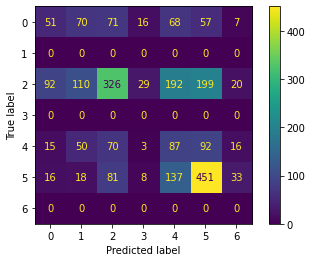

In [ ]:
model_ = Model_1.model.eval().to('cpu')
X = input_data[0]
Y = labels[0]
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y_pred.cpu(),Y.cpu())

In [ ]:
Net = [CNN_Net1]
LR = [0.001, 0.0015]
batch_size = [64, 50]
Momentum = [0.7,0.6,0.65]
epochs = [30]
weight_decay = [0, 0.0001]
loss_func  =  [nn.CrossEntropyLoss]
opt_func = [torch.optim.SGD]

grid = {
    'Net' : Net
    ,'LR' : LR
    ,'batch_size' : batch_size
    ,'Momentum' : Momentum
    ,'epochs' : epochs
    ,'weight_decay' :weight_decay
    ,'loss_func'  :loss_func
    ,'opt_func' : opt_func
}
params = sk.model_selection.ParameterGrid(grid)

In [ ]:
Hyper_Details = pd.DataFrame(columns=['hyper_param','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall','dataset'])
                                    
X_train = input_data[0].to(device)
Y_train = labels[0].to(device)
X_valid = input_data[1].to(device)
Y_valid = labels[1].to(device)
X_test = input_data[2].to(device)
Y_test = labels[2].to(device)

for p in params:
    Model_ = Model_Training2(**p, X_train = X_train , Y_train = Y_train, X_valid = X_valid , Y_valid= Y_valid)
    torch.manual_seed(0)
    Model_.train()
    
    model_ = Model_.model.eval()

    # Train
    Y_pred = model_(X_train.to(device)).argmax(axis=1)
    print(Y_pred.shape)
    Y = Y_train
    train_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )

    train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'))

    # # Valid
    # Y_pred = model_(X_valid).argmax(axis=1)
    # Y = Y_valid.argmax(axis=1)
    # valid_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
    # valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'))

    # # Test
    # Y_pred = model_(X_test).argmax(axis=1)
    # Y = Y_test.argmax(axis=1)
    # test_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
    # test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'))


    # dataset_name = "Standardized"
    # if i == 1:
    #     dataset_name  = "Sclade(0-1)"
    # elif i == 2:
    #     dataset_name = "Raw Data"

    # new_row = pd.Series({'hyper_param':p,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
    # ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall,'dataset':dataset_name}, name='')
    # CNN_Details = CNN_Details.append(new_row)

best_one = np.argmax(Hyper_Details.test_fscore)
best_param = Hyper_Details.iloc[best_one]['hyper_param']

CNN_Details = Hyper_Details

Model_1 = Model_Training2(**best_param, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid)
torch.manual_seed(0)
Model_1.train()

[Epoch: 0]  , Train_loss: 1.9 , Train_Acc: 18.0%, Val_loss: 1.9 , Val_Acc: 21.9% , run time: 1.05
[Epoch: 1]  , Train_loss: 1.9 , Train_Acc: 25.0%, Val_loss: 1.9 , Val_Acc: 21.9% , run time: 0.7
[Epoch: 2]  , Train_loss: 1.9 , Train_Acc: 25.0%, Val_loss: 1.9 , Val_Acc: 21.9% , run time: 0.72
Finished Training
torch.Size([2385])
[Epoch: 0]  , Train_loss: 1.9 , Train_Acc: 18.0%, Val_loss: 1.9 , Val_Acc: 21.9% , run time: 0.83
[Epoch: 1]  , Train_loss: 1.9 , Train_Acc: 25.0%, Val_loss: 1.9 , Val_Acc: 21.9% , run time: 0.69
[Epoch: 2]  , Train_loss: 1.9 , Train_Acc: 25.0%, Val_loss: 1.9 , Val_Acc: 21.9% , run time: 0.67
Finished Training
torch.Size([2385])
[Epoch: 0]  , Train_loss: 1.9 , Train_Acc: 21.3%, Val_loss: 1.9 , Val_Acc: 22.0% , run time: 1.56
[Epoch: 1]  , Train_loss: 1.9 , Train_Acc: 26.0%, Val_loss: 1.9 , Val_Acc: 22.0% , run time: 1.65
[Epoch: 2]  , Train_loss: 1.9 , Train_Acc: 26.0%, Val_loss: 1.9 , Val_Acc: 22.0% , run time: 1.67
Finished Training
torch.Size([2385])
[Epoch: 

KeyboardInterrupt: 

model_ = Model_1.model.eval()
X = input_data[2]
Y = labels[2]
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y_pred,Y)

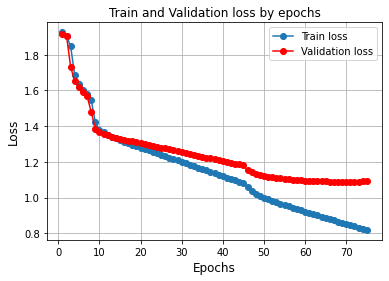

In [ ]:
model_ = Model_1
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_loss, 'o-', label='Train loss')
plt.plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation loss by epochs')
plt.show()

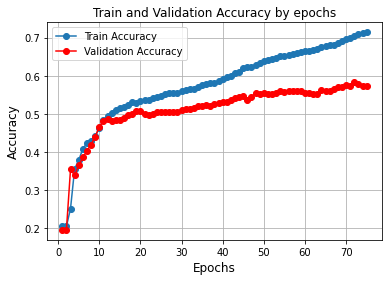

In [ ]:
model_ = Model_1
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_Acc, 'o-', label='Train Accuracy')
plt.plot(epochs_X , model_.Epochs_Val_Acc,'ro-', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation Accuracy by epochs')
plt.show()

# **Model 2: Net2**

In [ ]:
batch_size = 64
LR = 0.001
Momentum = 0.7
epochs = 75
model2 = CNN_Net2()
model2 = model2.to(device)  # put all model params on GPU.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr = LR, momentum = Momentum)
# optimizer = torch.optim.Adam(model2.parameters(), lr = LR, weight_decay=0.0003)
X_train = input_data[0]
Y_train = labels[0]
X_valid = input_data[1]
Y_valid = labels[1]
Model_2 = Model_Training( model2, loss_fn, optimizer, epochs, batch_size, X_train, Y_train, X_valid, Y_valid)

In [ ]:
Model_2.Train_CNNs()

[Epoch: 1]  , Train_loss: 1.8 , Train_Acc: 27.3%, Val_loss: 1.8 , Val_Acc: 30.9% , run time: 11.27
[Epoch: 2]  , Train_loss: 1.7 , Train_Acc: 32.7%, Val_loss: 1.6 , Val_Acc: 34.2% , run time: 10.92
[Epoch: 3]  , Train_loss: 1.5 , Train_Acc: 37.4%, Val_loss: 1.5 , Val_Acc: 41.0% , run time: 10.96
[Epoch: 4]  , Train_loss: 1.5 , Train_Acc: 42.5%, Val_loss: 1.5 , Val_Acc: 44.4% , run time: 10.96
[Epoch: 5]  , Train_loss: 1.4 , Train_Acc: 45.3%, Val_loss: 1.4 , Val_Acc: 46.7% , run time: 11.0
[Epoch: 6]  , Train_loss: 1.4 , Train_Acc: 46.6%, Val_loss: 1.4 , Val_Acc: 45.8% , run time: 10.97
[Epoch: 7]  , Train_loss: 1.4 , Train_Acc: 47.5%, Val_loss: 1.4 , Val_Acc: 46.9% , run time: 10.98
[Epoch: 8]  , Train_loss: 1.4 , Train_Acc: 48.0%, Val_loss: 1.4 , Val_Acc: 47.4% , run time: 11.02
[Epoch: 9]  , Train_loss: 1.4 , Train_Acc: 48.4%, Val_loss: 1.4 , Val_Acc: 47.4% , run time: 11.04
[Epoch: 10]  , Train_loss: 1.4 , Train_Acc: 48.8%, Val_loss: 1.4 , Val_Acc: 48.4% , run time: 11.12
[Epoch: 11

Nr. of Data : 
 451
Accuracy of The Model : 
 0.6008869179600886
Confusion Matrix : 
 [[18  6  3  1  5  3  0]
 [ 5 25  6  5  3  0  4]
 [ 1 14 77  1 26  9  0]
 [ 1  0  0  0  0  0  0]
 [ 3  2 20  0 41  5  1]
 [ 4  3 15  1 27 98  3]
 [ 0  1  1  0  1  0 12]]
Weighted Avg. of sensitivity : 
 0.4888228946915448
Weighted Avg. of specificity : 
 0.8956341098856812


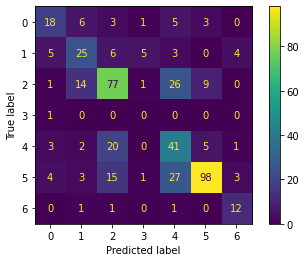

In [ ]:
model_ = model2.eval()
X = input_data[2]
Y = labels[2]
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y_pred,Y)

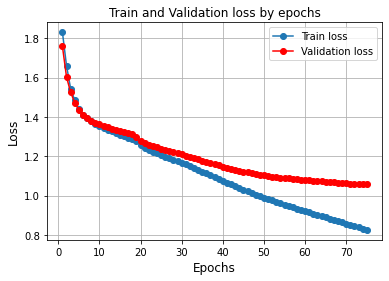

In [ ]:
model_ = Model_2
epochs_X = [i for i in range(1, model_.epochs+1)]
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_loss, 'o-', label='Train loss')
plt.plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation loss by epochs')
plt.show()

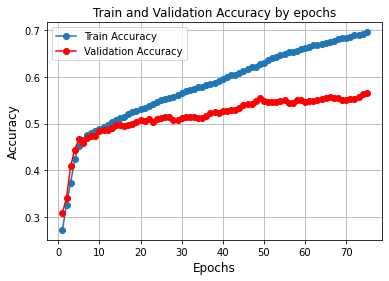

In [ ]:
model_ = Model_2
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_Acc, 'o-', label='Train Accuracy')
plt.plot(epochs_X , model_.Epochs_Val_Acc,'ro-', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation Accuracy by epochs')
plt.show()

# **Save the model**

In [ ]:
pickle.dump(Model_2, open(p_models + 'CNN_60x45_Duplicated', 'wb'))

In [ ]:
dill.dump([CNN_Net1,CNN_Net2,CNN_Net3, Model_Training], open(p_models + 'CNNs_Network_Training', "wb"))